# realbogus for realfast

## Machine Learning for VLA fast transient classification (using elastic search)

### By Umaa Rebbapragada and Casey Law

In [1]:
%matplotlib inline
import pylab as pl
import os.path
import numpy as np
import activegit, rflearn
from rtpipe.parsecands import read_candidates
import glob, logging
from IPython.display import Image, display

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

/Users/caseyjlaw/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
verbose = 0
random_seed = 1132014
np.random.seed(seed=random_seed)

def serveimage(imagename, baseurl='http://www.aoc.nrao.edu/~claw/plots/', width=700):
    display(Image(url=os.path.join(baseurl, imagename), width=width))

### Initialize activegit repo with classifier

In [3]:
agdir = os.path.join(os.environ['HOME'], 'code', 'alnotebook')
if not os.path.exists(agdir):
    agdir = raw_input("Specify activegit repo:")

if not os.path.exists(agdir):
    logger.info("ERROR: Cannot proceed without a valid notebook directory path")
else:    
    logger.info('Found activegit at {0}'.format(agdir))
    
ag = activegit.ActiveGit(agdir)

Found activegit at /Users/caseyjlaw/code/alnotebook


### Read new (unlabeled) candidates and prepare unlabeled pool

In [4]:
datalist = rflearn.elastic.indextodatalist(unclassified=True)
obslist, loc, prop = rflearn.elastic.restorecands(datalist)
stat_features = rflearn.features.stat_features(prop)

### Active learning loop

#### Take least certain predictions and ask expert to classify. Result is then fed back in to classifier to improve predictions.

In [5]:
# set up train, test and unlabeled pools
clf = ag.classifier
train_pool, train_targets = ag.training_data
test_pool, test_targets = ag.testing_data
unlabeled_pool_stat = stat_features

# set up batches
nunlabeled = len(obslist)
cands_unlabeled_pool = np.array(range(nunlabeled))
subset_threshold = 75
subset_perc = 0.666
n_jobs = 1
vers = [int(version.lstrip('stat')) for version in ag.versions if 'stat' in version]
batch_size=2
bi = 0 # batch index

nbatches = nunlabeled/batch_size
acc = np.zeros((nbatches, 1)) - 1
fnr = np.zeros((nbatches, 1)) - 1
fpr = np.zeros((nbatches, 1)) - 1

logger.info("TRAIN POOL SIZE: {0}".format(len(train_pool)))
logger.info("TRAIN TARGETS SIZE: {0}".format(len(train_targets)))
logger.info("UNLABELED POOL SIZE: {0}".format(unlabeled_pool_stat.shape))
logger.info("NUNLABELED: {0}".format(nunlabeled))

TRAIN POOL SIZE: 144
TRAIN TARGETS SIZE: 144
UNLABELED POOL SIZE: (385, 6)
NUNLABELED: 385


In [6]:
# START ACTIVE LEARNING LOOP
# 
while (nunlabeled > 0): # while still examples in unlabeled pool
    
    # get performance stats for classifier on validation set
    test_preds = clf.predict(test_pool)    
    acc[bi], fpr[bi], fnr[bi] = rflearn.features.calc_acc_fpr_fnr(test_targets, test_preds)
    print "BATCH %d acc, fpr, fnr: (%.3f, %.3f, %.3f)" % (bi, acc[bi], fpr[bi], fnr[bi])
        
    # choose a subset of the unlabeled pool to classify
    subset_size = int(np.floor(subset_perc * nunlabeled)) if (nunlabeled > subset_threshold) else nunlabeled
    cands_rand_subset = np.random.choice(cands_unlabeled_pool, subset_size, replace=False)
    subset_pool = unlabeled_pool_stat[cands_rand_subset,:]
        
    # classify that subset
    subset_pool_probs = clf.predict_proba(subset_pool) 
    
    # choose the most uncertain bunch to present to the user
    batch_subset_indices = (np.argsort(abs(subset_pool_probs[:,0] - subset_pool_probs[:,1])))[0:batch_size]
    batch_subset_probs = subset_pool_probs[batch_subset_indices,:]
    
    # ... finds the corresponding cands from the unlabeled pools
    batch_cand_indices = cands_rand_subset[batch_subset_indices]
    
    # present cand_indices to the user
    batch_cand_targets = []
    modified_data = []
    # move those examples into the training pool, remove them from the unlabeled pool
    for ci in range(batch_size):
        candi = batch_cand_indices[ci]
        logger.info('SNR = {0}'.format(unlabeled_pool_stat[candi,0]))
        logger.info("RDF Probs=({0},{1})".format(batch_subset_probs[ci,0], batch_subset_probs[ci,1]) )
        serveimage(datalist[candi]['candidate_png'])
        
        while 1:
            label = int(raw_input("LABEL: Is this real? (0,1) "))
            if label not in [0,1]:
                logger.warn("Please enter in 0 or 1 only")
                continue
            else:
                break

        batch_cand_targets.append(label)
        datalist[candi]['labeled'] = 1
        modified_data.append(datalist[candi])

    # update elastic search index to show that a batch has been classified
    rflearn.elastic.pushdata(modified_data)
    
    # augment train_pool, train_targets
    train_pool = np.vstack( (train_pool, unlabeled_pool_stat[batch_cand_indices,:]) )
    train_targets = np.concatenate( (train_targets, batch_cand_targets) )
    
    # remove from unlabeled pool candidates
    cands_unlabeled_pool = np.delete(cands_unlabeled_pool, batch_cand_indices, axis=0)
    nunlabeled = cands_unlabeled_pool.shape[0]
    bi += 1

    logger.info("TRAIN POOL SIZE: {0}".format(len(train_pool)))
    logger.info("TRAIN TARGETS SIZE: {0}".format(len(train_targets)))
    logger.info("UNLABELED POOL SIZE: {0}".format(cands_unlabeled_pool.shape))
    logger.info("NUNLABELED: {0}".format(nunlabeled))
    
    # re-train 
    logger.info("Retraining classifier...")
    clf = rflearn.sklearn_utils.train_random_forest(train_pool, train_targets, n_jobs=n_jobs, verbose=verbose, n_estimators=300)
    
    # ask to continue
    value = raw_input("Continue? (y,n): ")
    if value ==  'n':
        logger.info("Saving train, targets, and classifier to next version name...")
        rbv = 'stat{0}'.format(max(vers)+bi)
        ag.write_testing_data(test_pool, test_targets)
        ag.write_training_data([tuple(tr) for tr in train_pool], train_targets)
        ag.write_classifier(clf)
        #ag.commit_version(rbv)        
        break
    else:
        logger.info('Continuing training...')
    

SNR = 7.00779342651
RDF Probs=(0.5,0.5)


BATCH 0 acc, fpr, fnr: (0.981, 0.027, 0.012)


LABEL: Is this real? (0,1) 0


SNR = 7.03230476379
RDF Probs=(0.5,0.5)


LABEL: Is this real? (0,1) 0


TRAIN POOL SIZE: 146
TRAIN TARGETS SIZE: 146
UNLABELED POOL SIZE: (383,)
NUNLABELED: 383
Retraining classifier...


Continue? (y,n): y


Continuing...
SNR = 7.60138082504
RDF Probs=(0.49,0.51)


BATCH 1 acc, fpr, fnr: (0.981, 0.027, 0.012)


LABEL: Is this real? (0,1) 0


SNR = 7.57602453232
RDF Probs=(0.533333333333,0.466666666667)


LABEL: Is this real? (0,1) 0


TRAIN POOL SIZE: 148
TRAIN TARGETS SIZE: 148
UNLABELED POOL SIZE: (381,)
NUNLABELED: 381
Retraining classifier...


Continue? (y,n): n


Saving train, targets, and classifier to next version name...


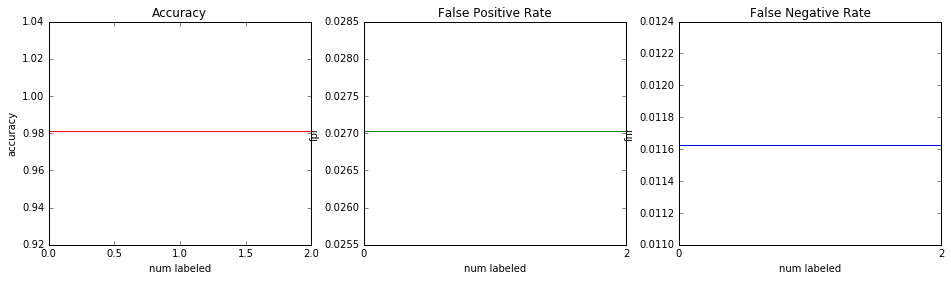

In [7]:
# plot out ACCURACY, FPR, FNR
nbatches = bi

pl.figure(figsize=(16,4))
pl.title('Active Learning Results')
batch_sizes = [ i*batch_size for i in range(nbatches) ]
pl.subplot(1,3,1)
pl.plot(batch_sizes, acc[:nbatches], 'r-')
pl.xlabel('num labeled')
pl.ylabel('accuracy')
pl.title('Accuracy')
pl.subplot(1,3,2)
pl.plot(batch_sizes, fpr[:nbatches], 'g-')
pl.title('False Positive Rate')
pl.ylabel('fpr')
pl.xlabel('num labeled')
pl.xticks(batch_sizes)
pl.subplot(1,3,3)
pl.plot(batch_sizes, fnr[:nbatches], 'b-')
pl.title('False Negative Rate')
pl.ylabel('fnr')
pl.xlabel('num labeled')

pl.xticks(batch_sizes)
pl.show()

        
    